In [0]:
import torch
from torchtext import data

import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import spacy

import time
import copy
from torch.optim import lr_scheduler

from torchtext.vocab import Vectors, GloVe
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Let's look at our dataset:

In [2]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Counting number of headlines with appropriate number of words:

In [3]:
count = df['headline'].str.split().apply(len).value_counts()
print(count)

10     3638
9      3425
11     3396
8      2935
12     2841
7      2404
13     2083
6      1762
14     1492
5      1164
15      969
4       591
16      578
17      383
3       306
18      228
19      143
2       118
20       63
21       45
22       23
23       12
24        5
27        3
25        2
28        2
29        2
31        1
38        1
39        1
26        1
30        1
151       1
Name: headline, dtype: int64


We can see, that most part of headlines has less then 24 words. We will use this fact for choosing length of sequence.

Dropping unusefull column:

In [4]:
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


We will use 20% of dataset as test set.

In [0]:
X = df['headline']
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Loading test and train sets to csv:

In [0]:
!mkdir torchtext_data

In [0]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv("torchtext_data/train.csv", index=False)
test_data.to_csv("torchtext_data/test.csv", index=False)

Prepearing data:

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
fix_length = 24
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [0]:
train_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [0]:
batch_size = 16

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=batch_size,
    device=device)

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 22895
Number of testing examples: 5724


Making vocabluary with GloVe with dimantion of 300:

In [13]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:32, 2.20MB/s]                          
100%|█████████▉| 399068/400000 [00:33<00:00, 12401.53it/s]

In [0]:
word_embeddings = TEXT.vocab.vectors
output_size = 2 #two classes
num_layers = 1
hidden_size = 64 #num of units in our NN
embedding_length = 300 #dim of GloVe vector
vocab_size = len(TEXT.vocab)

Defining the model:


*   Simple LSTM - LSTMClassifier class 
*   LSTM with Attanrion - AttantionLSTMClassifier class 
*   Bidirectional LSTM - BidirectionalLSTMClassifier class
*   Bidirectional LSTM with 2D MaxPool layer - LSTM2DMaxPoolClassifier class





In [0]:
from LSTM import *

In [0]:
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=6.98397e-05)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
dataiter_dict = {'train': train_iterator, 'val': test_iterator}
dataset_sizes = {'train':len(train_data), 'val':len(test_data)}

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 200

    val_loss = []
    train_loss = []
    val_acc = []
    train_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            sentiment_corrects = 0
            tp = 0.0 # true positive
            tn = 0.0 # true negative
            fp = 0.0 # false positive
            fn = 0.0 # false negative

            # Iterate over data.
            for batch in dataiter_dict[phase]:
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    text = batch.Text
                    label = batch.Label
                    label = torch.autograd.Variable(label).long()

                    if torch.cuda.is_available():
                      text = text.cuda()
                      label = label.cuda()
                    if (batch.Text.size()[1] is not batch_size):
                      continue
                    
                    outputs = model(text)
                    outputs = F.softmax(outputs,dim=-1)                   
                    loss = criterion(outputs, label)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * text.size(0)
                sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == label)

                tp += torch.sum(torch.max(outputs, 1)[1] & label)
                tn += torch.sum(1-torch.max(outputs, 1)[1] & 1-label)
                fp += torch.sum(torch.max(outputs, 1)[1] & 1-label)
                fn += torch.sum(1-torch.max(outputs, 1)[1] & label)
                
            epoch_loss = running_loss / dataset_sizes[phase]
           
            sentiment_acc = float(sentiment_corrects) / dataset_sizes[phase]

            if phase == 'train':
                train_acc.append(sentiment_acc)
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(sentiment_acc)
                val_loss.append(epoch_loss)

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} sentiment_acc: {:.4f}'.format(
                phase, sentiment_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'lstm_model_test.pth')

            if phase == 'val' and epoch == num_epochs - 1:
                recall = tp / (tp + fn)
                print('recall {:.2f}'.format(recall))

        print()

    confusion_matrix = [[float(tp), float(fp)],[float(fn), float(tn)]]
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(float(best_loss)))
    results = {'time': time_elapsed, 'recall': recall, 'conf_matr': confusion_matrix,
               'val_loss': val_loss, 'train_loss': train_loss, 'val_acc': val_acc, 'train_acc': train_acc}
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

Train model:

In [28]:
model_fit, res = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=8)

starting
Epoch 1/8
----------
train total loss: 0.8140 
train sentiment_acc: 0.7526
val total loss: 0.7261 
val sentiment_acc: 0.8188
saving with loss of 0.7261045663861608 improved over previous 200

Epoch 2/8
----------
train total loss: 0.6864 
train sentiment_acc: 0.8498
val total loss: 0.7043 
val sentiment_acc: 0.8325
saving with loss of 0.704286184325908 improved over previous 0.7261045663861608

Epoch 3/8
----------
train total loss: 0.6543 
train sentiment_acc: 0.8712
val total loss: 0.6842 
val sentiment_acc: 0.8482
saving with loss of 0.6842400637812585 improved over previous 0.704286184325908

Epoch 4/8
----------
train total loss: 0.6354 
train sentiment_acc: 0.8841
val total loss: 0.6892 
val sentiment_acc: 0.8403

Epoch 5/8
----------
train total loss: 0.6147 
train sentiment_acc: 0.8996
val total loss: 0.6762 
val sentiment_acc: 0.8548
saving with loss of 0.6762193800018519 improved over previous 0.6842400637812585

Epoch 6/8
----------
train total loss: 0.6069 
train s

Lets see at test and train accuracy plots:

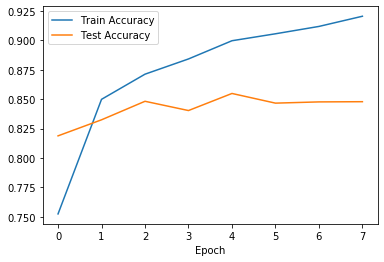

In [32]:
plt.plot(res['train_acc'], label = 'Train Accuracy')
plt.plot(res['val_acc'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.legend()

And confusion matrix:

In [35]:
pd.DataFrame(res['conf_matr'])

,0,1
0,2328.0,468.0
1,391.0,2525.0
